<a href="https://colab.research.google.com/github/ChengHanChiu/imtku_for_dial_eval_1/blob/master/dialog_quality_classification_blurr_fastai2_huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7335d719-0622-e0af-d623-ae3980de97d5)


In [ ]:
!pip3 install -U datascience albumentations pyarrow==0.17.1 transformers==3.0.2 fastai2==0.0.20 ohmeow-blurr==0.0.7

Requirement already up-to-date: datascience in /usr/local/lib/python3.6/dist-packages (0.15.6)
Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.4.6)
Requirement already up-to-date: pyarrow==0.17.1 in /usr/local/lib/python3.6/dist-packages (0.17.1)
Requirement already up-to-date: transformers==3.0.2 in /usr/local/lib/python3.6/dist-packages (3.0.2)
Requirement already up-to-date: fastai2==0.0.20 in /usr/local/lib/python3.6/dist-packages (0.0.20)
Requirement already up-to-date: ohmeow-blurr==0.0.7 in /usr/local/lib/python3.6/dist-packages (0.0.7)


In [ ]:
!pip3 check

No broken requirements found.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import json
from pathlib import Path

import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
DATA_DIR = Path('/content/drive/My Drive/NTCIR/ntcir15-master/LSTM-baseline-master/')
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
RNK2LBL = {2: 'A', 1: 'B', 0: 'C', -1: 'D', -2: 'E'}
LBL2RNK = {v: str(k) for k, v in RNK2LBL.items()}


def map_blank(txt):
    return ' xxblk ' if not txt else txt


def flatten_json_by_dialog(json_data, is_test=False):
    flattened_by_dlg = []
    for row in json_data:
        trns = row['turns']
        dlg_len = len(trns)
        dlg_txt = f'xxlen {dlg_len} <s> ' + ' </s> </s> '.join(
            (f'xxtrn {i+1} xxsdr {trn["sender"]} ' +
             ' '.join(map(map_blank, trn['utterances'])))
            for i, trn in enumerate(trns)
        ) + ' </s>'

        rcds = None
        if is_test:
            rcds = [{
                'id': row['id'],
                'label_a_e_s': None,
                'text': dlg_txt
            }]
        else:
            rcds = [
                {
                    'id': row['id'],
                    'label_a_e_s': ';'.join((
                        'a' + RNK2LBL[a['quality']['A']],
                        'e' + RNK2LBL[a['quality']['E']],
                        's' + RNK2LBL[a['quality']['S']],
                    )),
                    'text': dlg_txt
                } for a in row['annotations']
            ]
        flattened_by_dlg.extend(rcds)

    return flattened_by_dlg

In [ ]:
DS_NAMES = ('train', 'dev', 'test')
DS_LANGS = ('en', 'cn')

In [ ]:
for ds_name in DS_NAMES:
    for ds_lang in DS_LANGS:
        input_p = DATA_DIR / f'dataset/{ds_name}_{ds_lang}.json'
        output_p = DATA_DIR / f'{ds_name}_dq-{ds_lang}.csv'
        is_test = ds_name == 'test'

        json_f = open(input_p)
        json_d = json.load(json_f)
        json_f.close()
        df_by_dlg = pd.DataFrame(flatten_json_by_dialog(json_d, is_test))
        df_by_dlg.to_csv(
            output_p,
            columns=df_by_dlg.reindex(['label_a_e_s','text', 'id'])
        )

In [ ]:
import torch
from transformers import *
from fastai2.text.all import *

from blurr.data.all import *
from blurr.modeling.all import *

In [ ]:
task = HF_TASKS_AUTO.SequenceClassification
pretrained_model_name = 'bert-base-chinese'
(
    hf_arch,
    hf_config,
    hf_tokenizer,
    hf_model
) = BLURR_MODEL_HELPER.get_hf_objects(
    pretrained_model_name,
    task=task,
    config_kwargs={'num_labels': 15}
)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
len(hf_tokenizer)

21128

In [ ]:
hf_tokenizer.add_special_tokens({
    'additional_special_tokens': ['xxlen', 'xxtrn', 'xxsdr', 'xxblk']
})
hf_tokenizer.sanitize_special_tokens()
print(hf_tokenizer.all_special_tokens)

['[SEP]', 'xxblk', '[CLS]', 'xxsdr', 'xxlen', '[PAD]', 'xxtrn', '[MASK]', '[UNK]']


In [ ]:
len(hf_tokenizer)

21132

In [ ]:
hf_model.resize_token_embeddings(len(hf_tokenizer))

Embedding(21132, 768)

In [ ]:
trn_df = pd.read_csv(
    DATA_DIR / 'train_dq-cn.csv',
    usecols=('label_a_e_s', 'text')
)
trn_df = trn_df.assign(is_vld=False)
display(trn_df.head())
display(trn_df.text.str.split(' ').str.len().describe(percentiles=[.5, .95]))

vld_df = pd.read_csv(
    DATA_DIR / 'dev_dq-cn.csv',
    usecols=('label_a_e_s', 'text')
)
vld_df = vld_df.assign(is_vld=True)
display(vld_df.head())
display(vld_df.text.str.split(' ').str.len().describe(percentiles=[.5, .95]))

tst_df = pd.read_csv(
    DATA_DIR / 'test_dq-cn.csv',
    usecols=('text', 'id')
)
display(tst_df.head())
display(tst_df.text.str.split(' ').str.len().describe(percentiles=[.5, .95]))

,label_a_e_s,text,is_vld
0,aC;eE;sE,"xxlen 2 <s> xxtrn 1 xxsdr customer 中国电信的控制箱就这样吗？也没有人维护,信息安全和人身安全怎么保障？还是好好修修吧？这个应该不差钱吧？位于济南市新泺大街雅居园小区门对面.@中国电信 @中国电信客服 @中国电信济南客服 </s> </s> xxtrn 2 xxsdr helpdesk 您好,您反映的情况我们已认真记录,会及时向相关部门反馈,敬请等待[呵呵]； </s>",False
1,aC;eB;sE,"xxlen 2 <s> xxtrn 1 xxsdr customer 中国电信的控制箱就这样吗？也没有人维护,信息安全和人身安全怎么保障？还是好好修修吧？这个应该不差钱吧？位于济南市新泺大街雅居园小区门对面.@中国电信 @中国电信客服 @中国电信济南客服 </s> </s> xxtrn 2 xxsdr helpdesk 您好,您反映的情况我们已认真记录,会及时向相关部门反馈,敬请等待[呵呵]； </s>",False
2,aC;eB;sE,"xxlen 2 <s> xxtrn 1 xxsdr customer 中国电信的控制箱就这样吗？也没有人维护,信息安全和人身安全怎么保障？还是好好修修吧？这个应该不差钱吧？位于济南市新泺大街雅居园小区门对面.@中国电信 @中国电信客服 @中国电信济南客服 </s> </s> xxtrn 2 xxsdr helpdesk 您好,您反映的情况我们已认真记录,会及时向相关部门反馈,敬请等待[呵呵]； </s>",False
3,aC;eC;sC,"xxlen 2 <s> xxtrn 1 xxsdr customer 中国电信的控制箱就这样吗？也没有人维护,信息安全和人身安全怎么保障？还是好好修修吧？这个应该不差钱吧？位于济南市新泺大街雅居园小区门对面.@中国电信 @中国电信客服 @中国电信济南客服 </s> </s> xxtrn 2 xxsdr helpdesk 您好,您反映的情况我们已认真记录,会及时向相关部门反馈,敬请等待[呵呵]； </s>",False
4,aC;eC;sC,"xxlen 2 <s> xxtrn 1 xxsdr customer 中国电信的控制箱就这样吗？也没有人维护,信息安全和人身安全怎么保障？还是好好修修吧？这个应该不差钱吧？位于济南市新泺大街雅居园小区门对面.@中国电信 @中国电信客服 @中国电信济南客服 </s> </s> xxtrn 2 xxsdr helpdesk 您好,您反映的情况我们已认真记录,会及时向相关部门反馈,敬请等待[呵呵]； </s>",False


count    70300.000000
mean        34.854595
std         12.128986
min         16.000000
50%         34.000000
95%         54.000000
max        153.000000
Name: text, dtype: float64

,label_a_e_s,text,is_vld
0,aC;eC;sC,xxlen 4 <s> xxtrn 1 xxsdr customer #内涵段子# 联通你有些皮了！不过为你点赞 @中国联通 @中国联通客服 掌上营业厅（内涵段子的话题 也被封了_） 郑州·河南... ​ </s> </s> xxtrn 2 xxsdr helpdesk xxblk 小u来了 </s> </s> xxtrn 3 xxsdr customer 那夸夸你 </s> </s> xxtrn 4 xxsdr helpdesk xxblk </s>,True
1,aC;eC;sA,xxlen 4 <s> xxtrn 1 xxsdr customer #内涵段子# 联通你有些皮了！不过为你点赞 @中国联通 @中国联通客服 掌上营业厅（内涵段子的话题 也被封了_） 郑州·河南... ​ </s> </s> xxtrn 2 xxsdr helpdesk xxblk 小u来了 </s> </s> xxtrn 3 xxsdr customer 那夸夸你 </s> </s> xxtrn 4 xxsdr helpdesk xxblk </s>,True
2,aC;eC;sC,xxlen 4 <s> xxtrn 1 xxsdr customer #内涵段子# 联通你有些皮了！不过为你点赞 @中国联通 @中国联通客服 掌上营业厅（内涵段子的话题 也被封了_） 郑州·河南... ​ </s> </s> xxtrn 2 xxsdr helpdesk xxblk 小u来了 </s> </s> xxtrn 3 xxsdr customer 那夸夸你 </s> </s> xxtrn 4 xxsdr helpdesk xxblk </s>,True
3,aC;eC;sB,xxlen 4 <s> xxtrn 1 xxsdr customer #内涵段子# 联通你有些皮了！不过为你点赞 @中国联通 @中国联通客服 掌上营业厅（内涵段子的话题 也被封了_） 郑州·河南... ​ </s> </s> xxtrn 2 xxsdr helpdesk xxblk 小u来了 </s> </s> xxtrn 3 xxsdr customer 那夸夸你 </s> </s> xxtrn 4 xxsdr helpdesk xxblk </s>,True
4,aC;eC;sC,xxlen 4 <s> xxtrn 1 xxsdr customer #内涵段子# 联通你有些皮了！不过为你点赞 @中国联通 @中国联通客服 掌上营业厅（内涵段子的话题 也被封了_） 郑州·河南... ​ </s> </s> xxtrn 2 xxsdr helpdesk xxblk 小u来了 </s> </s> xxtrn 3 xxsdr customer 那夸夸你 </s> </s> xxtrn 4 xxsdr helpdesk xxblk </s>,True


count    7410.000000
mean       37.741026
std        13.157035
min        16.000000
50%        39.000000
95%        58.000000
max        74.000000
Name: text, dtype: float64

,id,text
0,4233862139754141,"xxlen 6 <s> xxtrn 1 xxsdr customer #工信投诉#中国联通在广州市番禺区汀沙村,未有通知下情况下进行光纤整改,并且停止了本人的光纤使用(光纤未到期),需要本人缴纳300元左右的整改费才愿意恢复网络.我想问,你们管不管？？？强制性消费吗？ @工信微报 @广州联通 @中国联通 @中国联通广东客服 </s> </s> xxtrn 2 xxsdr helpdesk 您好,关于您反映的问题,请私信方式提供您具体的宽带账号（如有绑定联通手机号码请一起提供）、宽带安装使用地址（番禺区*路*号*层）、有效的联系电话,以便小U详细记录交给工作人员跟进核查.谢谢！ </s> </s> xxtrn 3 xxsdr customer 私信了没人管 </s> </s> xxtrn 4 xxsdr helpdesk 小U暂时没有收到您的私信哦,烦请提供详细信息这边为您跟进的,谢谢！ </s> </s> xxtrn 5 xxsdr customer 图片评论 ¡评论配图 </s> </s> xxtrn 6 xxsdr helpdesk 您好,您反映的问题及提供的信息小U已知悉,并交到我司工作人员核查跟进,请您留意我司工作人员的联系回复哦,谢谢！ </s>"
1,4235334818389354,"xxlen 6 <s> xxtrn 1 xxsdr customer @中国联通湖南客服 @中国联通 用了几年了,每次回家就是这个效果～不给个解释吗～ </s> </s> xxtrn 2 xxsdr helpdesk 您好！我公司对网络建设和完善都非常重视,正在不断加强网络信号覆盖地域.关于您反馈的信号的问题,如方便,请您私信提供您的联系方式,以及发现网络弱区详细地址（***市**区***路**号**层）,以便我们核查信号覆盖情况后与您联系反馈.感谢您的理解与支持！ </s> </s> xxtrn 3 xxsdr customer 每次就是几个电话处理了 下次回家我会再来的…@中国联通湖南客服 </s> </s> xxtrn 4 xxsdr helpdesk 工作人员核实之后会第一时间联系您的,请您留意哦~ </s> </s> xxtrn 5 xxsdr customer 午回家还是没有改善,接着投诉电话打起～ </s> </s> xxtrn 6 xxsdr helpdesk 您可先关注使用情况,后期有任何问题可随时联系小U反馈哦~感谢您的理解与支持！ </s>"
2,4235390547973401,"xxlen 2 <s> xxtrn 1 xxsdr customer @搜狗输入法技术支持 能不能帮我找到我之前一个时间段所输入过的所有字.非常重要.谢谢您 2北京 · 五棵松 </s> </s> xxtrn 2 xxsdr helpdesk 您好,输入法无法找回您输入过的文字的功能,抱歉 </s>"
3,4235547189344573,"xxlen 4 <s> xxtrn 1 xxsdr customer VIVO手机连接车载蓝牙就会自己播放手机自带音乐怎么取消?@vivo客服 @vivo福建 2福州 · 竹岐乡 </s> </s> xxtrn 2 xxsdr helpdesk 您好,小v私信您了解下,请留意私信消息. </s> </s> xxtrn 3 xxsdr customer 升级系统了还是链接车载蓝牙就自动播放我的来电音乐 </s> </s> xxtrn 4 xxsdr helpdesk 小v在私信中为您解答,请留意私信消息. </s>"
4,4235569309558615,"xxlen 6 <s> xxtrn 1 xxsdr customer 专门买的美图手机用来拍照,里面几千张照片告诉我只能刷机,真是辣鸡#美图手机##拍照##美图#@美图手机 @美图手机官方客服 </s> </s> xxtrn 2 xxsdr helpdesk 亲亲,抱歉给您带来不便,这个是手机升级后为了保障安全改为6位密码,如果您这里密码不清楚是需要到网点检测查看下,小美与您私信方便与您沟通届时您可以查看下 </s> </s> xxtrn 3 xxsdr customer 官方客服并没有说密码是可以检测,直接让我去刷机,我在深圳九方实体店买的,我去网点后希望能有一个合理的解决方案 </s> </s> xxtrn 4 xxsdr helpdesk 亲亲,抱歉给您带来不便,这里您可以查看私信方便和您沟通哦 </s> </s> xxtrn 5 xxsdr customer 已经私信你了,通话网点人员被告知不能检测只能刷机,请有一个合理并可以实施的解决方案 </s> </s> xxtrn 6 xxsdr helpdesk 亲亲,小美这边已私信与您沟通了解,建议您到我们售后网点刷机处理呢,您后续有需要帮助可以私信联系小美或拨打客服热线4009909696,我们都将会竭诚为您服务 </s>"


count    300.000000
mean      36.720000
std       13.048466
min       16.000000
50%       35.000000
95%       57.000000
max       74.000000
Name: text, dtype: float64

In [ ]:
display(trn_df.text.iloc[0])
display(' '.join(hf_tokenizer.tokenize(trn_df.text.iloc[0])))

'xxlen 2 <s> xxtrn 1 xxsdr customer 中国电信的控制箱就这样吗？也没有人维护,信息安全和人身安全怎么保障？还是好好修修吧？这个应该不差钱吧？位于济南市新泺大街雅居园小区门对面.@中国电信 @中国电信客服 @中国电信济南客服 </s> </s> xxtrn 2 xxsdr helpdesk 您好,您反映的情况我们已认真记录,会及时向相关部门反馈,敬请等待[呵呵]； </s>'

'xxlen 2 < s > xxtrn 1 xxsdr c ##ust ##ome ##r 中 国 电 信 的 控 制 箱 就 这 样 吗 ？ 也 没 有 人 维 护 , 信 息 安 全 和 人 身 安 全 怎 么 保 障 ？ 还 是 好 好 修 修 吧 ？ 这 个 应 该 不 差 钱 吧 ？ 位 于 济 南 市 新 [UNK] 大 街 雅 居 园 小 区 门 对 面 . @ 中 国 电 信 @ 中 国 电 信 客 服 @ 中 国 电 信 济 南 客 服 < / s > < / s > xxtrn 2 xxsdr help ##desk 您 好 , 您 反 映 的 情 况 我 们 已 认 真 记 录 , 会 及 时 向 相 关 部 门 反 馈 , 敬 请 等 待 [ 呵 呵 ] ； < / s >'

In [ ]:
lang = 'cn'
trn_bs = 12
mdl_id = 'bert-base-chinese'

In [ ]:
blocks = (
    HF_TextBlock(hf_arch=hf_arch, hf_tokenizer=hf_tokenizer),
    MultiCategoryBlock()
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader('text'),
    get_y=ColReader('label_a_e_s', label_delim=';'),
    splitter=ColSplitter(col='is_vld')
)

In [ ]:
# %%timeit -n 1 -r 1 global trn_bs, dls
dls = dblock.dataloaders(trn_df.append(vld_df), bs=trn_bs, val_bs=128)

In [ ]:
display(trn_df.text.iloc[0])
display(' '.join(hf_tokenizer.tokenize(trn_df.text.iloc[0])))

'xxlen 2 <s> xxtrn 1 xxsdr customer 中国电信的控制箱就这样吗？也没有人维护,信息安全和人身安全怎么保障？还是好好修修吧？这个应该不差钱吧？位于济南市新泺大街雅居园小区门对面.@中国电信 @中国电信客服 @中国电信济南客服 </s> </s> xxtrn 2 xxsdr helpdesk 您好,您反映的情况我们已认真记录,会及时向相关部门反馈,敬请等待[呵呵]； </s>'

'xxlen 2 < s > xxtrn 1 xxsdr c ##ust ##ome ##r 中 国 电 信 的 控 制 箱 就 这 样 吗 ？ 也 没 有 人 维 护 , 信 息 安 全 和 人 身 安 全 怎 么 保 障 ？ 还 是 好 好 修 修 吧 ？ 这 个 应 该 不 差 钱 吧 ？ 位 于 济 南 市 新 [UNK] 大 街 雅 居 园 小 区 门 对 面 . @ 中 国 电 信 @ 中 国 电 信 客 服 @ 中 国 电 信 济 南 客 服 < / s > < / s > xxtrn 2 xxsdr help ##desk 您 好 , 您 反 映 的 情 况 我 们 已 认 真 记 录 , 会 及 时 向 相 关 部 门 反 馈 , 敬 请 等 待 [ 呵 呵 ] ； < / s >'

In [ ]:
torch.save(dls, DATA_DIR / f'dls-dq-{mdl_id}-{lang}-b{trn_bs}.pth')

In [ ]:
dls = torch.load(DATA_DIR / f'dls-dq-{mdl_id}-{lang}-b{trn_bs}.pth')

In [ ]:
dls.vocab

(#15) ['aA','aB','aC','aD','aE','eA','eB','eC','eD','eE'...]

In [ ]:
dls.show_batch()

,text,None
0,"2 < s > 1 customer 中 国 电 信 的 控 制 箱 就 这 样 吗 ？ 也 没 有 人 维 护, 信 息 安 全 和 人 身 安 全 怎 么 保 障 ？ 还 是 好 好 修 修 吧 ？ 这 个 应 该 不 差 钱 吧 ？ 位 于 济 南 市 新 大 街 雅 居 园 小 区 门 对 面. @ 中 国 电 信 @ 中 国 电 信 客 服 @ 中 国 电 信 济 南 客 服 < / s > < / s > 2 helpdesk 您 好, 您 反 映 的 情 况 我 们 已 认 真 记 录, 会 及 时 向 相 关 部 门 反 馈, 敬 请 等 待 [ 呵 呵 ] ； < / s >",aC;eE;sE
1,"6 < s > 1 customer 受 不 了 联 通 了, 先 是 不 停 打 电 话 跟 我 推 销 各 种 业 务, 等 到 真 正 有 需 求, 要 办 理 的 时 候, 说 法 又 是 前 后 不 一, 为 了 一 个 破 副 卡, 电 话 都 打 了 个 还 不 行, 希 望 以 后 客 服 都 专 业 点 儿, 别 忽 悠 客 户. 无 论 如 何, 用 完 这 个 套 餐 再 也 不 用 了 @ 中 国 联 通 广 东 客 服 < / s > < / s > 2 helpdesk 亲, 很 抱 歉, 请 问 关 于 副 卡 的 业 务, 您 是 遇 到 什 么 疑 问 了 呢 ？ 可 以 详 细 的 告 知 小 吗 ？ 小 协 助 您 核 查. 谢 谢. < / s > < / s > 3 customer 使 用 合 约 机, 128 套 餐, 但 由 于 当 时 购 机 时 登 记 身 份 证 为 家 人, 不 是 自 己, 现 其 在 国 外. 之 前 电 话 推 销 说 可 以 办 副 卡, 想 申 请, 电 话 咨 询 客 服, 解 释 清 楚 目 前 购 机 登 记 的 人 在 国 外, 但 手 机 是 我 在 使 用, 只 能 提 供 身 份 证 复 印 件, 客 服 说 可 以 办 理, 只 要 在 网 上 营 业 厅 申 请, 然 后 快 递 上 门 后 凭 身 份 证 复 印 件 即 可 领 取 副 卡, 跟 当 时 购 机 一 样. 结 果 我 弄 好 这 些, 电 话 客 服, 又 说 不 能 网 上 办 理, 只 能 携 带 身 份 证 原 件 去 营 业 厅. 前 后 说 法 不 一 致, 我 还 倒 着 时 差 问 家 人 要 身 份 证 复 印 件. 有 点 折 腾 人, 早 知 道 这 样, 就 不 会 打 算 办 副 卡 < / s > < / s > 4 helpdesk 亲, 很 抱 歉 给 您 带 来 不 好 的 感 知, 如 方 便, 请 您 私 信 提 供 一 下 联 通 号 码 和 联 系 电 话, 小 为 您 转 交 工 作 人 员 核 查, 谢 谢. < / s > < / s > 5 customer 你 好,",aC;eB;sD
2,"4 < s > 1 customer @ 中 国 联 通 客 服 百 思 不 得 其 解 我 2 月 份 的 流 量 很 诡 异 < / s > < / s > 2 helpdesk 您 好, 请 问 是 有 什 么 疑 问 呢 ？ < / s > < / s > 3 customer 明 明 有 一 个 剩 余 的 流 量 包, 为 什 么 还 会 有 超 出 的 流 量 使 用 < / s > < / s > 4 helpdesk 您 好, 您 提 及 的 情 况 @ 中 国 联 通 北 京 客 服 已 跟 进, 您 可 与 其 私 信 联 系 进 行 核 查 一 下 的. < / s >",aE;eB;sC
3,"5 < s > 1 customer @ 中 国 电 信 @ 中 国 电 信 北 京 客 服 你 们 家 的 天 气 预 报 是 超 前 还 是 滞 后 ？ 怎 么 报 下 雨 ？ 我 在 这 里 : 北 京 · 鹿 港... < / s > < / s > 2 helpdesk 童 鞋, 什 么 时 候 收 到 的 天 气 预 报 呢 ？ < / s > < / s > 3 customer 上 午 9 点. 刚 才 又 更 新 一 次, 仍 然 是 小 雨. < / s > < / s > 4 helpdesk 您 是 都 到 的 短 信 么 还 是 ？ < / s > < / s > 5 customer 写 错 别 字 啦 ！ 不 是 都 到 吧 ？ 应 该 是 收 到 吧 ？ 浮 躁 的 90 后 ？ 我 不 是 收 到 的 短 信 天 气 预 报. 你 们 发 送 短 信 天 气 预 报 吗 ？ 我 从 来 也 没 收 到 过. 是 手 机 桌 面 上 的 天 气 预 报 图 标, 通 过 连 接 你 家 网 络 更 新 的. 不 准 确 的 时 候 很 多. < / s >",aC;eD;sE
4,"6 < s > 1 customer @ 乐 视 超 级 电 视 @ 乐 视 客 服 团 长 @ 乐 视 商 城 买 的 x3 _ 50 才 几 个 月, 老 是 黑 屏 闪 屏, 每 次 闪 一 到 两 秒 钟, 怎 么 回 事 ？ 怎 么 办 ？ < / s > < / s > 2 helpdesk 您 好, 抱 歉 给 您 带 来 不 便 了, 请 问 您 在 所 有 信 号 源 下 均 显 示 吗 ？ < / s > < / s > 3 customer 平 时 都 只 是 看 直 播 的 信 号, 其 他 信 号 源 没 怎 么 用 过, 没 注 意 是 否 也 闪 屏 < / s > < / s > 4 helpdesk 您 好, 麻 烦 您 核 实 下 在 其 他 信 号 源 下 是 否 也 会 出 现 这 个 情 况 呢 ~ < / s > < / s > 5 customer 它 是 基 本 是 三 四 十 分 钟 出 现 一 次 闪 屏, 印 象 中 好 像 其 他 信 号 源 出 现 过 < / s > < / s > 6 helpdesk 团 长 私 信 您 处 理, 麻 烦 您 查 收 下 ~ < / s >",aE;eE;sE
5,"3 < s > 1 customer 老 罗, 希 望 锤 子 科 技 的 客 服 部 门 和 法 务 部 门 能 澄 清 一 下 此 事 是 否 存 在. 如 果 是, 如 何 解 决. 如 果 不 是, 公 司 （ 老 罗 英 语 ） 楼 下 就 是 法 院, 你 懂 的. @ 罗 永 浩 @ 朱 萧 木 @ 锤 子 科 技 @ 锤 子 科 技 客 服 < / s > < / s > 2 helpdesk 您 好, 目 前 我 们 还 没 有 收 到 用 户 关 于 这 方 面 的 反 馈. < / s > < / s > 3 customer 如 果 真 此 事 为 真, 希 望 锤 子 科 技 能 发 扬 老 罗 的 风 格, 不 掖 着 藏 着. 如 果 是 造 谣, 希 望 锤 子 科 技 更 要 发 扬 老 罗 的 风 格, 告 到 无 良 媒 体 腿 软. < / s >",aC;eC;sD
6,"6 < s > 1 customer @ 马 连 道 茶 城 @ 一 商 集 团 @ 中 国 联 通 北 京 客 服 什 么 时 候 能 改 造 下 北 京 马 连 道 茶 城 ( 一 商 大 厦 ) 的 宽 带 呢 ？ 啥 时 候 能 升 级 个 光 纤 啊 ？ 现 在 的 带 宽 太 慢 了 ！ 跟 不 上 这 个 网 络 时 代 的 步 伐 啊 北 京 · 粮 呈... < / s > < / s > 2 helpdesk 您 可 登 录 北 京 宽 带 网 （ www. bbn. com. cn ） 查 询 光 纤 覆 盖 情 况, 如 已 覆 盖 可 通 过 网 页 链 接 沃 宽 客 户 端 办 理 光 纤 改 造 业 务. < / s > < / s > 3 customer 就 是 因 为 没 有 光 纤 覆 盖 呢, 所 以 想 反 馈 下, 希 望 联 通 和 马 连 道 茶 城 协 商 解 决 < / s > < / s > 4 helpdesk 您 是 否 申 请 过 光 改 ？ 最 近 什 么 时 间 申 请 过 吗 ？ < / s > < / s > 5 customer 当 时 到 营 业 厅 就 说 要 办 光 纤 的, 可 是 营 业 员 说 那 大 厦 办 不 了, 只 能 办 的 带 宽 的 < / s > < / s > 6 helpdesk 若 确 实 存 在 客 观 条 件, 不 具 备 安 装 条 件, 暂 不 能 办 理 光 改 哦. 我 公 司 也 在 积 极 推 进 改 造 工 作, 您 再 关 注. < / s >",aB;eC;sC
7,"3 < s > 1 customer @ 音 悦 客 服 台 亲, 我 的 视 频 上 传 已 经 快 半 个 月 了, 怎 么 还 不 给 通 过 啊 每 次 都 这 样, 很 让 人 伤 心 哎 ！ ！ ！ 能 不 能 过, 给 个 痛 快 话 行 不 ？ < / s > < / s > 2 helpdesk 抱 歉 耽 误 您 的 审 核 啦 亲 您 将 编 号 给 我 一 下 马 上 帮 您 查 看 < / s

In [ ]:
tst_dl = dls.test_dl(tst_df.text.tolist(), bs=128)

In [ ]:
torch.save(tst_dl, DATA_DIR / f'tst_dl-dq-{mdl_id}-{lang}.pth')

In [ ]:
tst_dl = torch.load(DATA_DIR / f'tst_dl-dq-{mdl_id}-{lang}.pth')

In [ ]:
mdl = HF_BaseModelWrapper(hf_model)
lrnr = Learner(
    dls,
    mdl,
    opt_func=partial(Adam, decouple_wd=True),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[
        accuracy_multi,
        APScoreMulti(average='weighted'),
        F1ScoreMulti(average='weighted'),
        JaccardMulti(average='weighted'),
    ],
    cbs=[HF_BaseModelCallback],
    splitter=hf_splitter,
    path=DATA_DIR,
)
lrnr = lrnr.to_fp16()
lrnr.create_opt()

In [ ]:
# lrnr.blurr_summary()

In [ ]:
# lrnr.freeze()

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.14454397559165955)

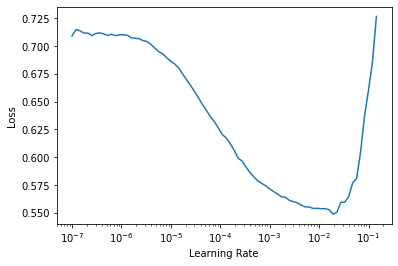

In [ ]:
lrnr.lr_find(suggestions=True)

In [ ]:
lrnr.fit_one_cycle(1, lr_max=slice(2e-6, 2e-3))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,f1_score,jaccard_score,time
0,0.411742,0.418269,0.811930,0.416878,0.201904,0.134548,43:04


In [ ]:
cl_name = f'{mdl_id}-b{trn_bs}-cl1_lr2En3'
lrnr.save(f'dialog_cf-{lang}-{cl_name}')

In [ ]:
def save_quality_submission_json(
    cl_name,
    lang='cn',
    lrnr=lrnr,
    tst_dl=tst_dl,
    labels=dls.vocab,
    tst_df=tst_df,
    folder=DATA_DIR,
):
    preds, _ = lrnr.get_preds(dl=tst_dl)
    scrs_lst = [dict([*zip(labels, scrs.tolist())]) for scrs in preds]

    ranks_dict_lst = []
    for lbl_scrs_dict in scrs_lst:
        ranks_dict = {'A': dict(), 'E': dict(), 'S': dict()}
        for lbl, scr in lbl_scrs_dict.items():
            ranks_dict[lbl[0].upper()][str(LBL2RNK[lbl[1]])] = scr
        ranks_dict_lst.append(ranks_dict)

    out_df = tst_df.assign(quality=ranks_dict_lst)
    out_df.id = out_df.id.astype(str)
    out_df[['id', 'quality']].to_json(
        DATA_DIR / f'quality_{lang}_submission-{cl_name}.json',
        orient='records',
        indent=2
    )

In [ ]:
save_quality_submission_json(cl_name, tst_dl=tst_dl, tst_df=tst_df)

In [ ]:
# lrnr.lr_find(suggestions=True)

In [ ]:
lrnr.fit_one_cycle(1, lr_max=slice(2e-6, 2e-3))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,f1_score,jaccard_score,time
0,0.409722,0.417864,0.812605,0.419223,0.211277,0.139740,43:48


In [ ]:
cl_name += '-cl1_lr2En3'
lrnr.save(f'dialog_cf-{lang}-{cl_name}')

In [ ]:
save_quality_submission_json(cl_name)

In [ ]:
lrnr.fit_one_cycle(1, lr_max=slice(2e-6, 2e-3))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,f1_score,jaccard_score,time
0,0.409605,0.418797,0.811660,0.418251,0.210687,0.139824,44:00


In [ ]:
cl_name += '-cl1_lr2En3'
lrnr.save(f'dialog_cf-{lang}-{cl_name}')

In [ ]:
save_quality_submission_json(cl_name)

In [ ]:
# lrnr.export(fname=f'{cl_name}.pkl')

In [ ]:
# trn_cf = load_learner(fname=f'{cl_name}.pkl')
# lrnr.get_preds()

In [ ]:
# lrnr.lr_find(suggestions=True)

In [ ]:
lrnr.fit_one_cycle(1, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,f1_score,jaccard_score,time
0,0.408671,0.417590,0.812596,0.420036,0.211799,0.140642,44:01


In [ ]:
cl_name += '-cl1_lr1En3'
lrnr.save(f'dialog_cf-{lang}-{cl_name}')

In [ ]:
save_quality_submission_json(cl_name)

In [ ]:
# lrnr.export(fname=f'{cl_name}.pkl')

In [ ]:
# lrnr.lr_find(suggestions=True)

In [ ]:
lrnr.fit_one_cycle(1, lr_max=slice(5e-7, 5e-4))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,f1_score,jaccard_score,time
0,0.412799,0.417458,0.812749,0.421693,0.218648,0.144063,44:00


In [ ]:
cl_name += '-cl1_lr5En4'
lrnr.save(f'dialog_cf-{lang}-{cl_name}')

In [ ]:
save_quality_submission_json(cl_name)

In [ ]:
lrnr.fit_one_cycle(1, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,f1_score,jaccard_score,time
0,0.407130,0.417540,0.812659,0.421802,0.222979,0.146950,43:58


In [ ]:
cl_name += '-cl1_lr1En4'
lrnr.save(f'dialog_cf-{lang}-{cl_name}')

In [ ]:
save_quality_submission_json(cl_name)

In [ ]:
lrnr.export(fname=f'{cl_name}.pkl')